In [ ]:
# IMPOTING ALL THE NECESSARY LIBRARIES

# STEP 1: Import all required libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Successfully Imported all the Libraries")

Successfully Imported all the Libraries


In [ ]:
# DOWNLOADING THE DATASET

from tensorflow.keras.datasets import cifar10

# This line will automatically download the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Successfully Downloaded the Dataset")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Successfully Downloaded the Dataset


In [ ]:
# Dataset Confirmation

print("Training images shape:", x_train.shape)
print("Training labels shape:", y_train.shape)

print("\nYes Dataset Has been Downloaded Successfully")

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)

Yes Dataset Has been Downloaded Successfully


In [ ]:
# Data Preprocessing

# 1. Normalize image data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


In [ ]:
# Mapping: vehicle = 0, animal = 1, solid object = 2
def map_labels(y):
    mapped = []
    for label in y:
        if label in [0, 1, 9]:         # airplane, automobile, truck → vehicle
            mapped.append(0)
        elif label in [2, 3, 4, 5, 6, 7]:  # bird, cat, deer, dog, frog, horse → animal
            mapped.append(1)
        elif label == 8:               # ship → solid object
            mapped.append(2)
    return np.array(mapped)

y_train_mapped = map_labels(y_train.flatten())
y_test_mapped = map_labels(y_test.flatten())


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train_mapped, num_classes=3)
y_test_encoded = to_categorical(y_test_mapped, num_classes=3)


In [ ]:
# Data Preprocessing Confirmation

print("1. Check Image Data Normalization (Pixel Range 0–1\n")

print("Min pixel value:", x_train.min())
print("Max pixel value:", x_train.max())


print("\n2. Check Shape of Mapped & Encoded Labels\n")

print("Mapped train labels shape:", y_train_mapped.shape)
print("One-hot encoded train labels shape:", y_train_encoded.shape)

print("\n3. Print Sample Encoded Labels\n")

print("First 5 original mapped labels:", y_train_mapped[:5])
print("First 5 one-hot labels:\n", y_train_encoded[:5])


print("\nPreprocessing Phase has been Completed Successfully")

1. Check Image Data Normalization (Pixel Range 0–1

Min pixel value: 0.0
Max pixel value: 1.0

2. Check Shape of Mapped & Encoded Labels

Mapped train labels shape: (50000,)
One-hot encoded train labels shape: (50000, 3)

3. Print Sample Encoded Labels

First 5 original mapped labels: [1 0 0 1 0]
First 5 one-hot labels:
 [[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]

Preprocessing Phase has been Completed Successfully


In [ ]:
# ✅ FAST + SAFE MODEL TRAINING SETUP

import tensorflow as tf
import pandas as pd
import numpy as np
import tempfile
import os
import shutil

# ✅ Basic settings
IMG_SHAPE = (160, 160)  # Smaller image size for speed
BATCH_SIZE = 32
EPOCHS = 10

# ✅ Class labels (same as before)
class_labels = ['vehicle', 'animal', 'solid obj']
def decode_labels(one_hot_labels):
    return [class_labels[np.argmax(label)] for label in one_hot_labels]

# ✅ Save images to temp dirs
train_dir = tempfile.mkdtemp()
test_dir = tempfile.mkdtemp()

def save_images_and_create_df(images, labels, directory):
    image_paths = []
    for i, image in enumerate(images):
        file_path = os.path.join(directory, f"{i}.png")
        tf.keras.utils.save_img(file_path, image)
        image_paths.append(file_path)
    return pd.DataFrame({'image': image_paths, 'label': decode_labels(labels)})

train_df = save_images_and_create_df(x_train[:3000], y_train_encoded[:3000], train_dir)  # smaller dataset
val_df = save_images_and_create_df(x_test[:1000], y_test_encoded[:1000], test_dir)

# ✅ Data generators
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_generator = train_gen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=IMG_SHAPE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)
validation_generator = val_gen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=IMG_SHAPE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

# ✅ TPU or GPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("✅ Using TPU")
except:
    strategy = tf.distribute.MirroredStrategy()
    print("✅ Using GPU or CPU")

# ✅ Define & compile model in strategy scope
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# ✅ Save checkpoints so you don’t lose progress
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_checkpoint.h5", save_best_only=True)

# ✅ Train
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb]
)

# ✅ Clean up temp dirs
shutil.rmtree(train_dir)
shutil.rmtree(test_dir)

print("\n✅ Training Done Successfully")


Found 3000 validated image filenames belonging to 3 classes.
Found 1000 validated image filenames belonging to 3 classes.
✅ Using GPU or CPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - accuracy: 0.7148 - loss: 0.6952

94/94 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7155 - loss: 0.6937 - val_accuracy: 0.8070 - val_loss: 0.4902
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.8664 - loss: 0.3726

94/94 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.8664 - loss: 0.3723 - val_accuracy: 0.8340 - val_loss: 0.4202
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8875 - loss: 0.3016 - val_accuracy: 0.8340 - val_loss: 0.4327
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.8893 - loss: 0.2823

94/94 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.8893 - loss: 0.2824 - val_accuracy: 0.8450 - val_loss: 0.3988
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.8964 - loss: 0.2612

94/94 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8964 - loss: 0.2612 - val_accuracy: 0.8530 - val_loss: 0.3678
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.9163 - loss: 0.2347

94/94 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9162 - loss: 0.2348 - val_accuracy: 0.8650 - val_loss: 0.3621
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8996 - loss: 0.2455 - val_accuracy: 0.8790 - val_loss: 0.3901
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9114 - loss: 0.2440 - val_accuracy: 0.8470 - val_loss: 0.3777
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8971 - loss: 0.2432 - val_accuracy: 0.8630 - val_loss: 0.3830
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.9185 - loss: 0.2320

94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9186 - loss: 0.2319 - val_accuracy: 0.8800 - val_loss: 0.3553

✅ Training Done Successfully


In [ ]:
# RECTREATE TEMPORARY TEST DITECTORIES
import tempfile, os, pandas as pd
from tensorflow.keras.utils import save_img

test_dir = tempfile.mkdtemp()

def decode_labels(one_hot_labels):
    return [class_labels[np.argmax(label)] for label in one_hot_labels]

def save_images_and_create_df(images, labels, directory):
    image_paths = []
    for i, image in enumerate(images):
        file_path = os.path.join(directory, f"{i}.png")
        save_img(file_path, image)
        image_paths.append(file_path)
    return pd.DataFrame({'image': image_paths, 'label': decode_labels(labels)})

test_df = save_images_and_create_df(x_test, y_test_encoded, test_dir)


In [ ]:
# RECREATE THE TEST DATA GENERATOR
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image",
    y_col="label",
    class_mode="categorical",
    batch_size=32,
    target_size=(224, 224)
)


Found 10000 validated image filenames belonging to 3 classes.


In [ ]:
# EVALUATE TEST ACCURACY
loss, accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 434s 1s/step - accuracy: 0.7985 - loss: 0.5381
Test Accuracy: 79.16%


In [ ]:
# SAVING
model.save("mobilenetv2_classifier.keras")


In [ ]:
# DEFINING THE PREDICTION FUNCTION

from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

class_labels = ['vehicle', 'animal', 'solid obj']

def predict_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions)

    print(f"Predicted class: {predicted_class} ({confidence * 100:.2f}%)")


Saving BOAT2.jpg to BOAT2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


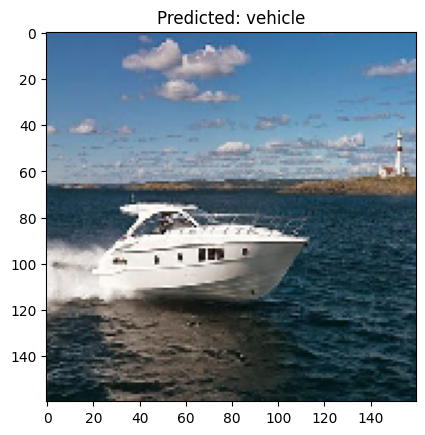

Predicted Class: vehicle


In [ ]:
from google.colab import files  # If you're using Google Colab

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Step 1: Upload the image (this step is for Colab)
uploaded = files.upload()

# Step 2: Load the uploaded image
img_path = list(uploaded.keys())[0]  # Get the path of the uploaded image

# Step 3: Load the saved model
model = load_model('mobilenetv2_classifier.keras')

# Step 4: Preprocess the image for MobileNetV2 (change target size to (160, 160))
img = image.load_img(img_path, target_size=(160, 160))  # Resize image to 160x160
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Preprocess as required by MobileNetV2

# Step 5: Predict the class
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Define class labels (same as used during training)
class_labels = ['vehicle', 'animal', 'solid obj']

# Get the predicted class label
predicted_class = class_labels[predicted_class_index]

# Step 6: Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.show()

# Print the prediction
print(f"Predicted Class: {predicted_class}")
